# Final policy notebook
This notebook contains all code used for the report from the Gelderland analysts.

## Loading of model

In [29]:
import os
import random
import shutil
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ema_workbench import (
    Policy,
    Scenario,
    ema_logging,
    MultiprocessingEvaluator,
    load_results,
    Constraint, ScalarOutcome,
)
from ema_workbench import Samplers, save_results
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol
from ema_workbench.analysis import prim, parcoords
from ema_workbench.em_framework.optimization import ArchiveLogger, EpsilonProgress
from problem_formulation import get_model_for_problem_formulation

ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

## Preliminary Sensitivity Analysis

In [30]:
# Run sensitivity analysis with SOBOL sampling
dike_model, _ = get_model_for_problem_formulation(6)

def get_do_nothing_dict():
    return {l.name: 0 for l in dike_model.levers}

num_scens = 1024
policy = Policy("no release", **get_do_nothing_dict())

# with MultiprocessingEvaluator(dike_model) as evaluator:
#     results = evaluator.perform_experiments(scenarios=num_scens, policies=policy, uncertainty_sampling=Samplers.SOBOL)
# save_results(results, f"{num_scens}_sen_SOBOL_np2.tar.gz")

In [31]:
# Load results from previous run
results = load_results('1024_sen_SOBOL_np2.tar.gz')
experiments, outcomes = results

rings = ["A.1", "A.2", "A.3", "A.4", "A.5"]
data = pd.DataFrame(outcomes)

[MainProcess/INFO] results loaded successfully from C:\Users\larsk\Documents\Studie\Industrial_Ecology\Q4\MBDM\assignments\final assignment\1024_sen_SOBOL_np2.tar.gz


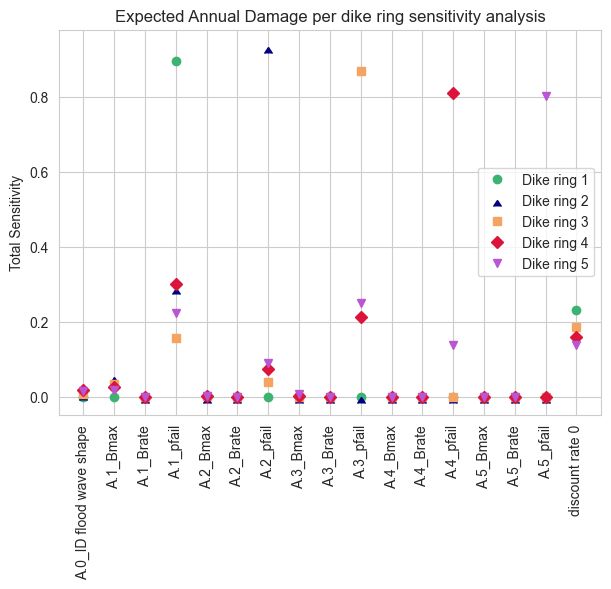

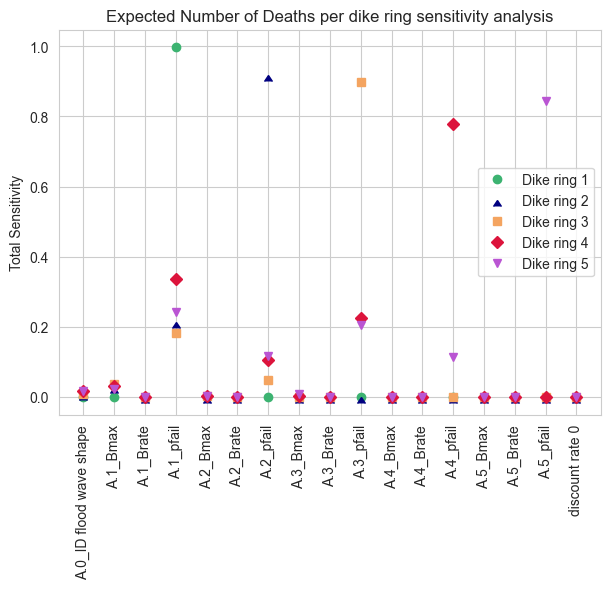

In [32]:
# Plot sensitivity of damages and deaths per dike ring
strings = ["_Expected Annual Damage", "_Expected Number of Deaths"]
cols = ["mediumseagreen", "navy", "sandybrown", "crimson", "mediumorchid"]
markers = ["o", 6, "s", "D", "v"]
for j in range(len(strings)):
    for i in range(len(rings)):

        y = outcomes[f'{rings[i]}{strings[j]}']
        problem = get_SALib_problem(dike_model.uncertainties)
        Si = sobol.analyze(problem, y, calc_second_order=True, print_to_console=False) # Run SOBOL analysis on outcomes

        lst = Si.to_df()
        df = pd.concat(lst)
        if i == 0:
            ax = df.plot(y="ST", marker=markers[i], color=cols[i], linestyle="", rot=90, figsize=(7, 5),
                         label=f"Dike ring {i + 1}")
        else:
            df.plot(y="ST", marker=markers[i], color=cols[i], linestyle="", rot=90, label=f"Dike ring {i + 1}", ax=ax)

    ax.set_xticks(range(17))
    ax.set_xticklabels([ind for ind in df.index[:17]], rotation=90)
    ax.grid(visible=True)
    plt.title(f"{strings[j][1:]} per dike ring sensitivity analysis")
    plt.ylabel("Total Sensitivity")
    plt.savefig(f"./figures/Sensitivity {strings[j][1:]}")
    plt.show()

## PRIM global sensitivity analysis

In [33]:
# Return policy for business-as-usual case
dike_model, planning_steps = get_model_for_problem_formulation(2)

def get_do_nothing_dict():
    return {l.name: 0 for l in dike_model.levers}

bau_policy = Policy("no policy", **get_do_nothing_dict())

In [34]:
# Evaluate business-as-usual with SOBOL
# with MultiprocessingEvaluator(dike_model) as evaluator:
#     results = evaluator.perform_experiments(scenarios=1000, policies=bau_policy, uncertainty_sampling=Samplers.SOBOL)
# from ema_workbench import save_results
#
# save_results(results, "Base_scenario_pf2.tar.gz")

In [35]:
# Load results from previous run
results_bau = "Base_scenario_pf2.tar.gz"
experiments, outcomes = load_results(results_bau)

[MainProcess/INFO] results loaded successfully from C:\Users\larsk\Documents\Studie\Industrial_Ecology\Q4\MBDM\assignments\final assignment\Base_scenario_pf2.tar.gz


[MainProcess/INFO] mean: 0.6513911620294599, mass: 0.050916666666666666, coverage: 0.6659230340211936, density: 0.6513911620294599 restricted_dimensions: 5


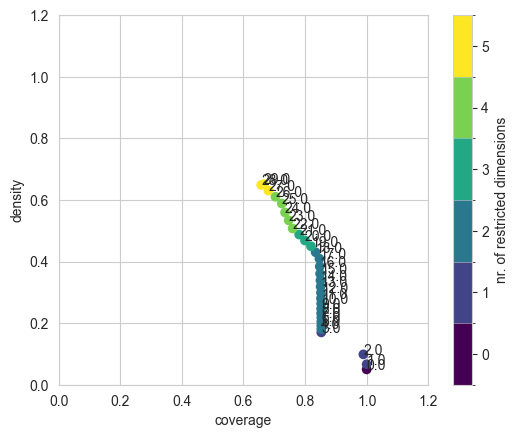

<Figure size 640x480 with 0 Axes>

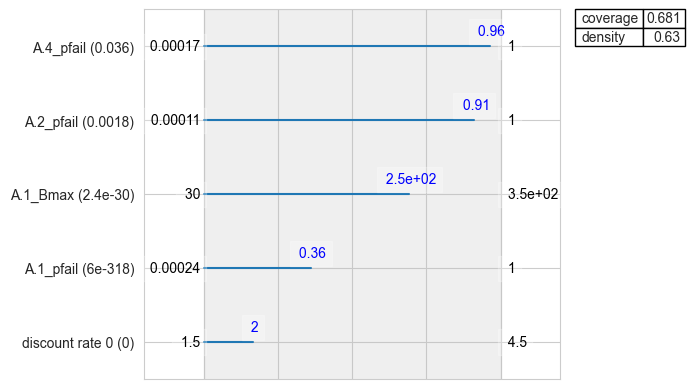

[MainProcess/INFO] resample 0
[MainProcess/INFO] resample 1
[MainProcess/INFO] resample 2
[MainProcess/INFO] resample 3
[MainProcess/INFO] resample 4
[MainProcess/INFO] resample 5
[MainProcess/INFO] resample 6
[MainProcess/INFO] resample 7
[MainProcess/INFO] resample 8
[MainProcess/INFO] resample 9


,reproduce coverage,reproduce density
A.1_Bmax,100.0,100.0
A.1_pfail,100.0,100.0
A.2_pfail,100.0,100.0
discount rate 0,100.0,100.0
A.4_pfail,70.0,40.0
A.0_ID flood wave shape,0.0,0.0
A.1_Brate,0.0,0.0
A.2_Bmax,0.0,0.0
A.2_Brate,0.0,0.0
A.3_Bmax,0.0,0.0


<Figure size 640x480 with 0 Axes>

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 36000 points remaining, containing 1793 cases of interest
[MainProcess/INFO] mean: 0.6513911620294599, mass: 0.050916666666666666, coverage: 0.6659230340211936, density: 0.6513911620294599 restricted_dimensions: 5


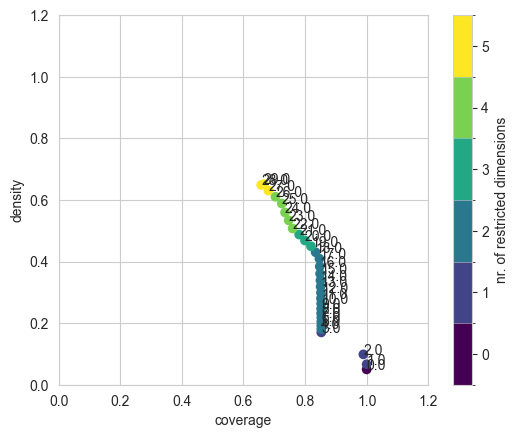

<Figure size 640x480 with 0 Axes>

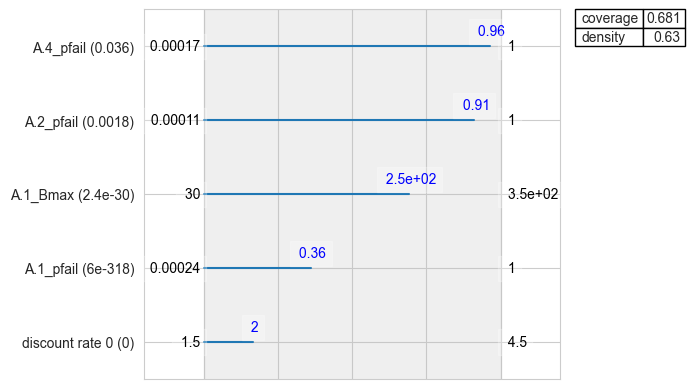

[MainProcess/INFO] resample 0
[MainProcess/INFO] resample 1
[MainProcess/INFO] resample 2
[MainProcess/INFO] resample 3
[MainProcess/INFO] resample 4
[MainProcess/INFO] resample 5
[MainProcess/INFO] resample 6
[MainProcess/INFO] resample 7
[MainProcess/INFO] resample 8
[MainProcess/INFO] resample 9


,reproduce coverage,reproduce density
A.1_Bmax,100.0,100.0
A.1_pfail,100.0,100.0
A.2_pfail,100.0,100.0
discount rate 0,100.0,100.0
A.4_pfail,30.0,20.0
A.3_pfail,20.0,0.0
A.0_ID flood wave shape,0.0,0.0
A.1_Brate,0.0,0.0
A.2_Bmax,0.0,0.0
A.2_Brate,0.0,0.0


<Figure size 640x480 with 0 Axes>

In [41]:
# Prim analysis for the 5% highest annual damage outcomes
dike_model, planning_steps = get_model_for_problem_formulation(2)
outcome_of_interest = outcomes['Expected Annual Damage']
x = experiments.drop(labels=[l.name for l in dike_model.levers], axis=1)
y = outcome_of_interest > np.percentile(outcome_of_interest, 95)
prim_alg = prim.Prim(x, y, threshold=0.5, peel_alpha=0.06)  # Variables chosen for good interpretability
box = prim_alg.find_box()

box.show_tradeoff(annotated=True)
plt.show()
plt.savefig("./figures/Prim tradeoff")

# Pick box which has a relatively high density and interpretability
point = len(box.box_lims) - 6
box.inspect(point, style='graph')
box.select(point)
plt.show()
plt.savefig("./figures/Prim box")

box.resample(point)

In [42]:
# Create reference scenario
lims_as_dict = box.box_lim.to_dict(orient="records")
for i in range(len(lims_as_dict)):
    del lims_as_dict[i]['discount rate 0']

av_dict = {}

# Take mean for each box dimension
for key in lims_as_dict[0].keys():
    av_dict[key] = (lims_as_dict[0][key] + lims_as_dict[1][key]) / 2
    if "Brate" in key or key == "A.0_ID flood wave shape":
        av_dict[key] = np.round(av_dict[key]).astype(int)

ref_scen = Scenario(**av_dict)

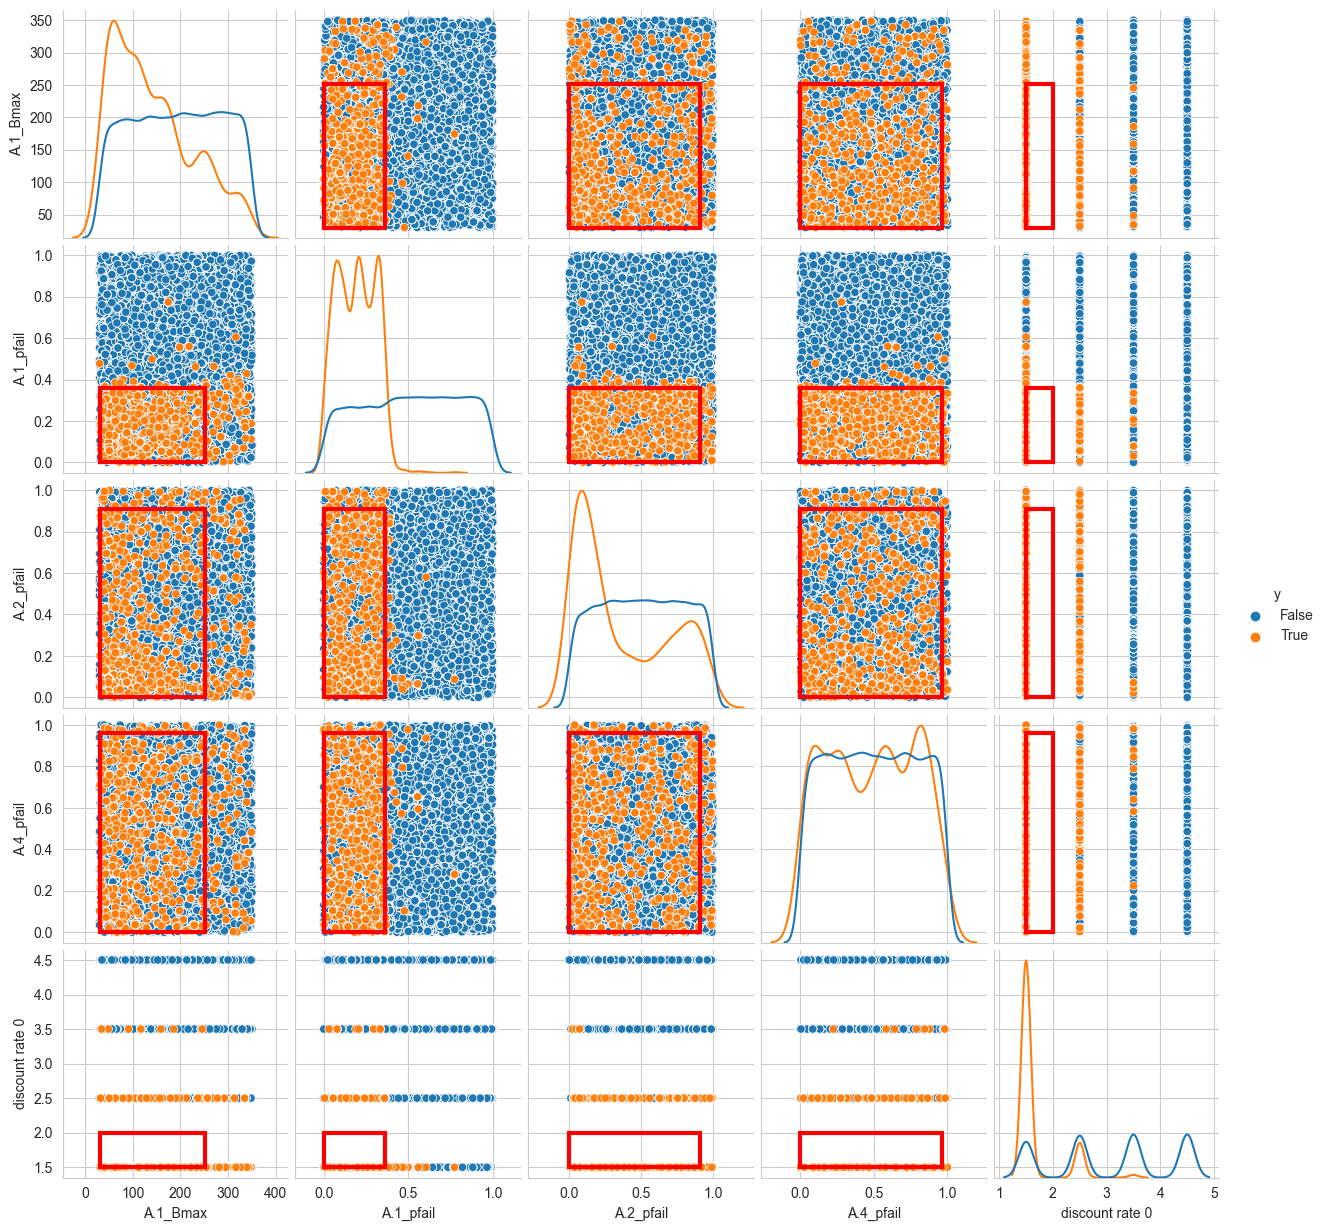

<Figure size 640x480 with 0 Axes>

In [43]:
# Show scatter plot with cases of interest in box
box.show_pairs_scatter()
fig = plt.gcf()
plt.show()
plt.savefig("./figures/PRIM scatter")

## MOEA

In [53]:
MOEA_runs = 5
results = []
convergences = []

nfes = 100000
eps = [1e6, 5e7, 1e8, 1e6, 0.1]  # Values are chosen to obtain ~5 solutions per run
constraints = [Constraint("max damages", outcome_names="Expected Annual Damage",
                          function=lambda x: max(0, x - 5e6))]  # Add constraint for 5mln damage maximum

# Find policies in 5 different runs
# with MultiprocessingEvaluator(dike_model) as evaluator:
#     for i in range(MOEA_runs):
#         if os.path.isdir('./tmp'):
#             shutil.rmtree('./tmp')
#
#         random.seed(i)  # Choose seed for reproducibility
#
#         # Save epsilon progress as convergence metric
#         convergence_metrics = [
#             ArchiveLogger(
#                 "./",
#                 [l.name for l in dike_model.levers],
#                 [o.name for o in dike_model.outcomes],
#                 base_filename=f"convergence_run{i}.tar.gz"),
#             EpsilonProgress()]
#
#         result, convergence = evaluator.optimize(
#             nfe=nfes,
#             searchover="levers",
#             epsilons=eps,
#             convergence=convergence_metrics,
#             constraints=constraints,
#             reference=ref_scen)  # Uses the reference scenario obtained earlier with PRIM
#         results.append(result)
#         convergences.append(convergence)

In [54]:
# # Save results
# with open(f"results_{0}", "wb") as fp:
#     pickle.dump(results, fp)
#
# with open(f"convergences_{0}", "wb") as fp:
#     pickle.dump(convergences, fp)

In [55]:
# Load results
seed = 0
with open(f"results_{seed}", "rb") as fp:
    results = pickle.load(fp)

with open(f"convergences_{seed}", "rb") as fp:
    convergences = pickle.load(fp)

In [56]:
# Show outcomes and save policy
outcome_keys = np.copy(list(outcomes.keys()))
MOEA_policies = np.array([{} for _ in range(MOEA_runs)])

for run in range(MOEA_runs):
    outcomes = results[run].loc[:,
               ['Expected Annual Damage', 'Dike Investment Costs', 'RfR Investment Costs', 'Evacuation Costs',
                'Expected Number of Deaths']]

    # Save policies
    policies_df = results[run].drop(outcome_keys, axis=1)
    policies_dict = policies_df.to_dict(orient="records")
    MOEA_policies[run] = policies_dict

np.save(f"policies_{seed}.npy", MOEA_policies)

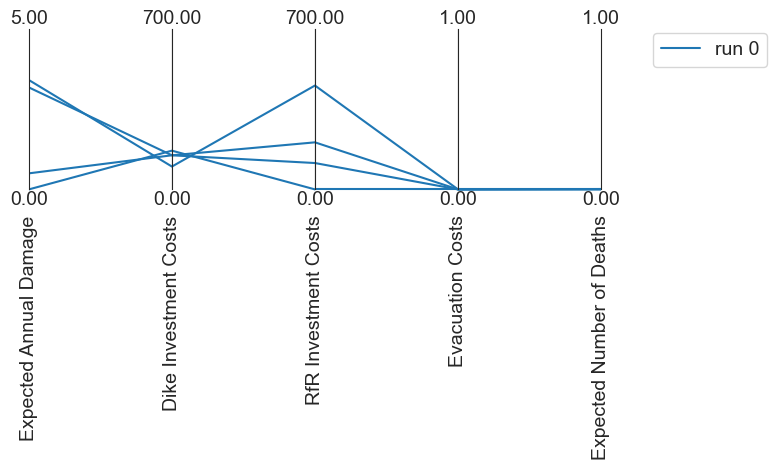

<Figure size 640x480 with 0 Axes>

In [57]:
# Plot tradeoffs in outcomes
scale = 1e6

limits = pd.DataFrame([[0, 0, 0, 0, 0], [5, 700, 700, 1, 1]], columns=outcome_keys)
axes = parcoords.ParallelAxes(limits)

for i, (result, color) in enumerate(zip(results, sns.color_palette())):
    outcomes = result.loc[:, outcome_keys]
    # Scale costs to millions
    for key in outcome_keys:
        if key != 'Expected Number of Deaths':
            outcomes[key] = outcomes[key] / scale
    axes.plot(outcomes, color=color, label='run {}'.format(i))

axes.legend()
plt.show()
plt.savefig("./figures/MOEA runs")


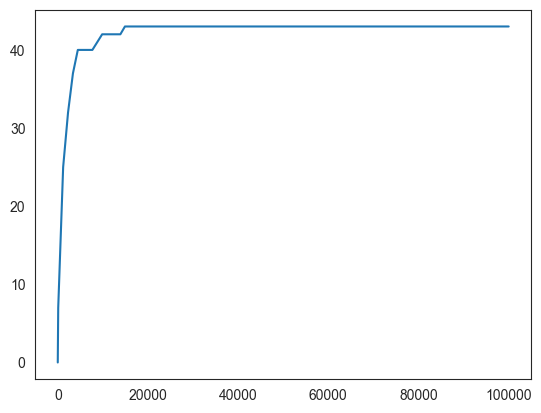

<Figure size 640x480 with 0 Axes>

In [58]:
# Plot epsilon convergences
for i in range(len(convergences)):
    plt.plot(convergences[i].nfe, convergences[i].epsilon_progress)
plt.show()
plt.savefig("./figures/epsilon_convergences")

## Evaluate policies

In [59]:
# Load policies
policies_dict = np.load("policies.npy", allow_pickle=True)
pol_names = [f"pol_{100 * i + j}" for i in range(MOEA_runs) for j in range(len(policies_dict[i]))]
policies = [Policy(f"pol_{100 * i + j}", **policies_dict[i][j]) for i in range(MOEA_runs) for j in
            range(len(policies_dict[i]))]

In [60]:
# Save evaluation of policies with different scenarios
num_scen = 1000
# with MultiprocessingEvaluator(dike_model) as evaluator:
#     results_new = evaluator.perform_experiments(num_scen, policies=policies)
# save_results(results_new, "re-evaluation.tar.gz")

In [61]:
# Load evaluation of policies from previous run
results_new = load_results("re-evaluation.tar.gz")
exp_new, out_new = results_new

[MainProcess/INFO] results loaded successfully from C:\Users\larsk\Documents\Studie\Industrial_Ecology\Q4\MBDM\assignments\final assignment\re-evaluation.tar.gz


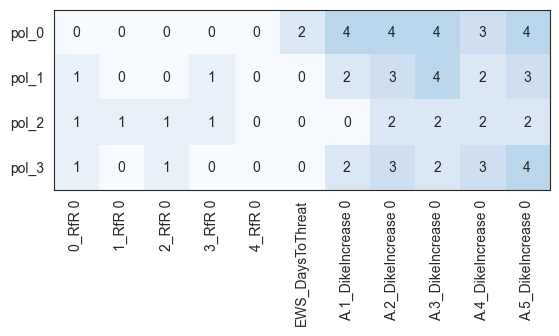

<Figure size 640x480 with 0 Axes>

In [62]:
# Make a table listing the measures taken for each policy
measures = [f"{j}_RfR 0" for j in range(5)] + ["EWS_DaysToThreat"] + [f"A.{i + 1}_DikeIncrease 0" for i in range(5)]
policies_list = []
for i in range(len(policies_dict)):
    policies_list.append(list(zip(*map(dict.values, policies_dict[i]))))

distance = 0
end_dist = 0

# Convert the 2D list with tuples into a table
pol_arr = np.zeros((len(measures), len(policies)))
for i in range(len(policies_list)):
    distance = end_dist
    for j in range(len(policies_list[i])):
        temp_dist = distance
        for k in range(len(policies_list[i][j])):
            pol_arr[j, temp_dist] = policies_list[i][j][k]
            temp_dist += 1
        end_dist = temp_dist

pol_arr = pol_arr.T
for (j, i), label in np.ndenumerate(pol_arr):
    plt.text(i, j, int(label), ha='center', va='center')
plt.imshow(pol_arr, cmap="Blues", vmax=14)
plt.xticks(np.arange(len(measures)), measures, rotation=90)
plt.yticks(np.arange(len(pol_names)), pol_names)
plt.show()
plt.savefig("./figures/Policy table")

ValueError: could not broadcast input array from shape (400,) into shape (1000,)

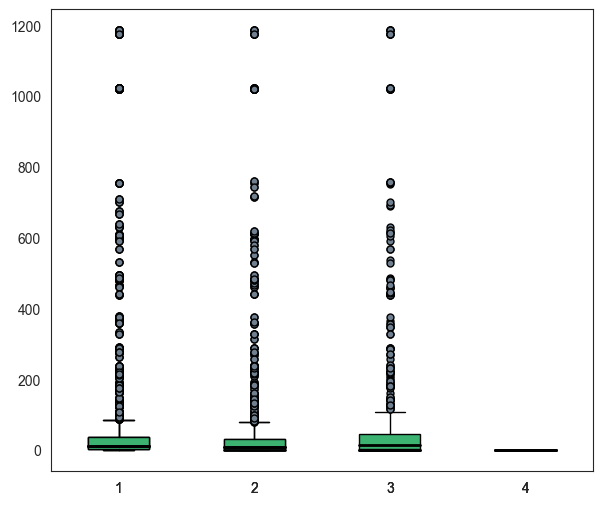

In [63]:
# Plot damages with a boxplot per policy
scale = 1e6

outcome = "Expected Annual Damage"
num_pols = len(policies)
plt.figure(figsize=(7, 6))
expected_damages_per_pol = np.zeros((num_scen, len(policies)))
for i in range(len(policies)):
    expected_damages_per_pol[:, i] = out_new[outcome][i * num_scen:(i + 1) * num_scen]
    plt.boxplot(expected_damages_per_pol / scale, medianprops=dict(color="black", linewidth=2),
                patch_artist=True,
                boxprops=dict(facecolor="mediumseagreen"),
                flierprops={'marker': 'o', 'markersize': 5, 'markerfacecolor': 'slategrey'})
plt.ylabel("Annual damages (million euros)")
# plt.xticks(range(1, 6), range(5))
plt.xlabel("Policy")
#plt.yscale("log")
plt.savefig("./figures/Annual_damages_final", dpi=200)
plt.show()

In [ ]:
# Plot deaths with a boxplot per policy
outcome = "Expected Number of Deaths"
num_pols = len(policies)
plt.figure(figsize=(7, 6))
deaths_per_pol = np.zeros((num_scen, len(policies)))

for i in range(len(policies)):
    deaths_per_pol[:, i] = out_new[outcome][i * num_scen:(i + 1) * num_scen]
    plt.boxplot(deaths_per_pol, medianprops=dict(color="black", linewidth=2),
                patch_artist=True,
                boxprops=dict(facecolor="mediumseagreen"),
                flierprops={'marker': 'o', 'markersize': 5, 'markerfacecolor': 'slategrey'})
plt.ylabel("Annual deaths")
plt.xlabel("Policy")
plt.savefig("./figures/Annual_deaths_final", dpi=200)
plt.show()

In [ ]:
# Show investments as a barchart per policy
investments_per_pol = np.zeros((num_scen, len(policies)))
investments = ['Dike Investment Costs', 'RfR Investment Costs', 'Evacuation Costs']

for i in range(len(policies)):
    for j in investments:
        investments_per_pol[:, i] += out_new[j][i * num_scen:(i + 1) * num_scen]
x = [*range(len(policies))]
plt.bar(x, investments_per_pol[0, :int(num_pols)] / scale, color="salmon")
plt.xticks(range(len(policies)), range(len(policies)))
plt.ylabel("Total investment costs (million euros)")
plt.xlabel("Policy")
plt.savefig("./figures/Total_investment", dpi=200)
plt.tight_layout()
plt.show()

## Robustness: Signal to noise

In [ ]:
# Signal to noise calculation
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)

    if direction == ScalarOutcome.MAXIMIZE:
        return mean / std
    else:
        return mean * std

In [ ]:
# Calculate StN for each policy
overall_scores = {}
for policy in np.unique(exp_new['policy']):
    scores = {}

    logical = exp_new['policy'] == policy

    for outcome in dike_model.outcomes:
        value = out_new[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T

In [ ]:
# Show scores
df = scores
data = (df - df.min()) / (df.max() - df.min())
limits = parcoords.get_limits(data)
data = data.fillna(0.5)
limits.loc[0, [outcome.name for outcome in dike_model.outcomes]] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()
plt.savefig("./figures/Robustness")